In [1]:
from collections import Counter
import json 
import os
import os.path as path
from pprint import pprint
import re
from datetime import datetime, timedelta
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

In [2]:
# directories
root_dir = path.dirname(os.getcwd())
logs_dir = path.join(root_dir, f"logs/reddit")
outs_dir = path.join(root_dir, f"output/reddit")
original_dir = path.join(root_dir, f"data/reddit/original")
preprocessed_dir = path.join(root_dir, f"data/reddit/preprocessed")

# constants
START = datetime(2020, 1, 1)
END = datetime(2022, 1, 1)
N_DATES = (END - START).days
ALL_DATES = set([START + timedelta(i) for i in range(N_DATES)])

## Scraping overview

In [3]:
# load scraping logs for posts and comments
modes = ['posts', 'comments']
logs = {mode: [] for mode in modes}

for mode in modes:
    mode_dir = path.join(logs_dir, mode)
    filepaths = [
        path.join(mode_dir, filename) 
        for filename in sorted(os.listdir(mode_dir))]

    # load logs as dataframe
    df = []
    for filepath in filepaths:
        with open(filepath, 'r') as f:
            x = json.load(f)
            assert x['mode'] == mode
            
            df.append(x)
    logs[mode] = pd.DataFrame(df)
    display(logs[mode].head()) # peek

,mode,date_scraped,run_date,shard_data,time_taken
0,posts,2020-01-01,2022-01-30 15:14,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",11.9s
1,posts,2020-01-02,2022-01-30 15:14,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",12.5s
2,posts,2020-01-03,2022-01-30 15:14,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",11.7s
3,posts,2020-01-04,2022-01-30 15:15,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",16.2s
4,posts,2020-01-05,2022-01-30 15:15,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",22.8s


,mode,date_scraped,run_date,shard_data,time_taken
0,comments,2020-01-01,2022-01-30 13:22,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",14.7s
1,comments,2020-01-02,2022-01-30 13:22,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",16.7s
2,comments,2020-01-03,2022-01-30 13:23,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",16.3s
3,comments,2020-01-04,2022-01-30 13:23,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",16.5s
4,comments,2020-01-05,2022-01-30 13:23,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",13.5s


Total number of days: 731
Missing days: []
Number of days with posts fully scraped: 419
Number of days with no scraping metadata: 0


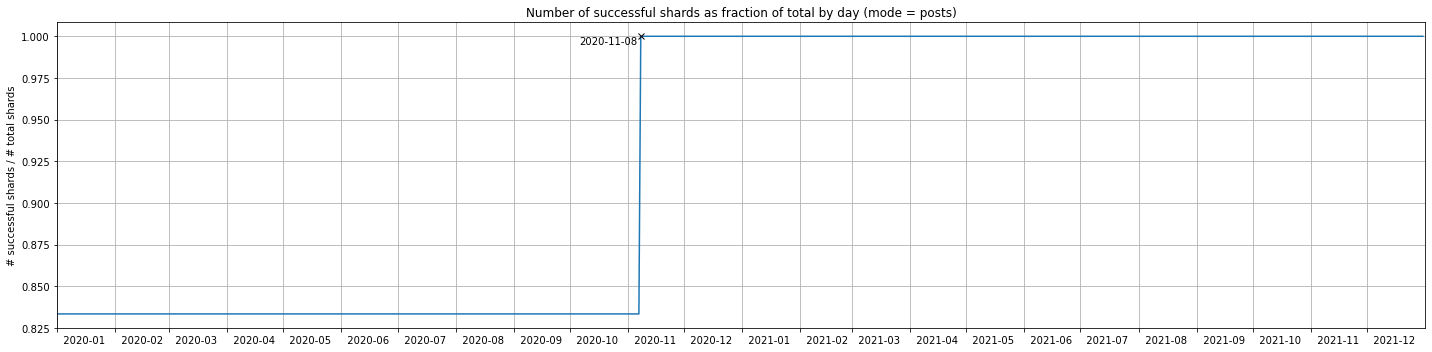

Total number of days: 713
Missing days: ['2021-01-10', '2021-01-25', '2021-01-26', '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-11', '2021-09-05', '2021-09-06', '2021-09-21', '2021-09-25', '2021-09-26', '2021-09-28', '2021-12-15', '2021-12-16', '2021-12-20', '2021-12-25', '2021-12-26']
Number of days with comments fully scraped: 401
Number of days with no scraping metadata: 0


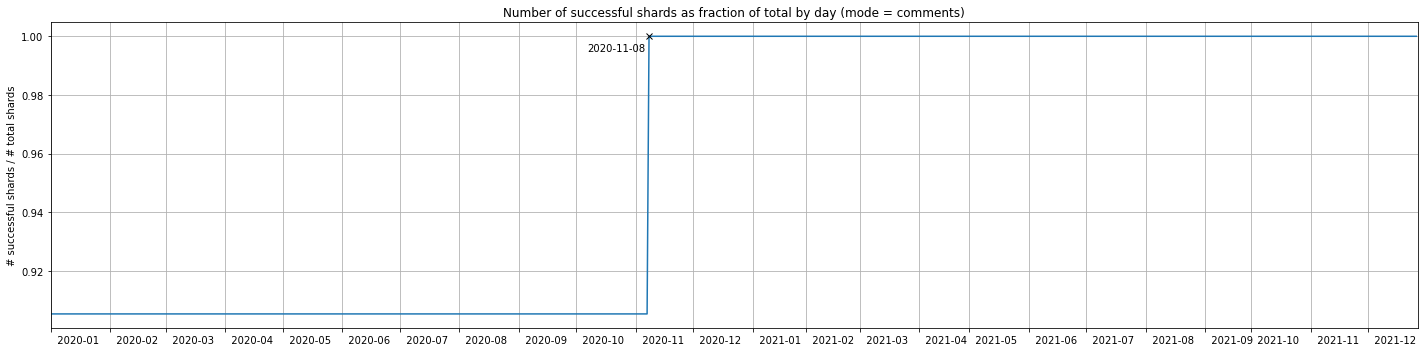

In [4]:
# compute and plot scraping statistics based on shard_data
# if n_successful/n_total != 1, then some data may be missing

for mode in modes:
    df = logs[mode]

    n_successful = np.array(df.shard_data.apply(
        lambda x: x['successful'] if x is not None else 0))
    n_total = np.array(df.shard_data.apply(
        lambda x: x['total'] if x is not None else 1))
        
    # report any missing dates
    prettydates = df.date_scraped.tolist()
    dates = [datetime(*[int(_) for _ in x.split('-')]) for x in prettydates]
    missing_dates = [x.strftime('%Y-%m-%d') for x in ALL_DATES - set(dates)]

    print(f"Total number of days: {len(prettydates)}")
    print(f"Missing days: {sorted(missing_dates)}")
    print(f"Number of days with {mode} fully scraped: {sum(n_successful == n_total)}")
    print(f"Number of days with no scraping metadata: {df.shard_data.apply(lambda x: x is None).sum()}")

    if True:
        plt.figure(figsize=(20, 5))
        plt.plot(n_successful / n_total)
        
        idx = np.where(n_successful == n_total)[0][0]
        plt.plot(idx, 1, marker='x', color='black')
        plt.text(idx-2, 0.995, s=prettydates[idx], ha='right')

        plt.title(f"Number of successful shards as fraction of total by day (mode = {mode})")
        plt.ylabel("# successful shards / # total shards")
        plt.xlim(0, len(prettydates))
        plt.xticks(
            ticks=[i for i, x in enumerate(prettydates) if x.endswith("01")], 
            labels=["  " + x[:-3] for x in prettydates if x.endswith("01")], 
            ha="left")

        plt.grid()
        plt.tight_layout()
        plt.show()

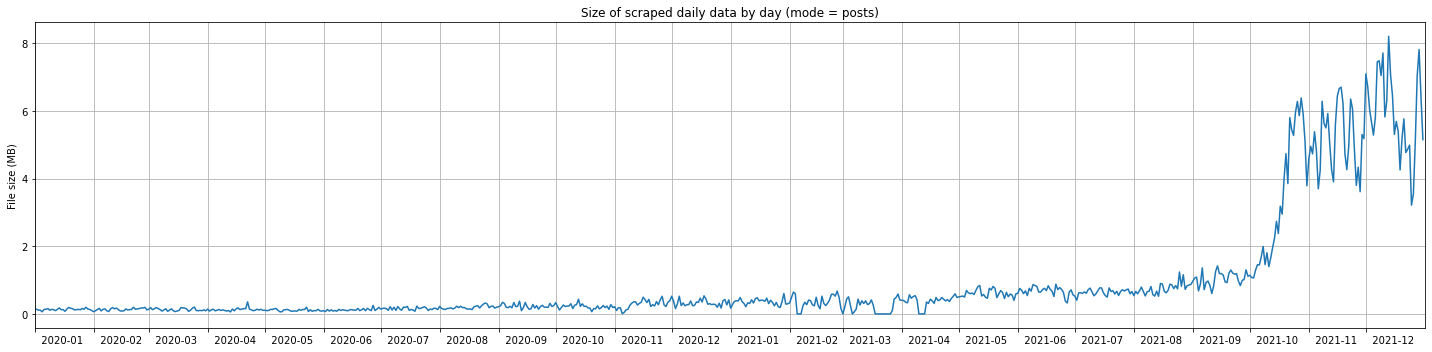

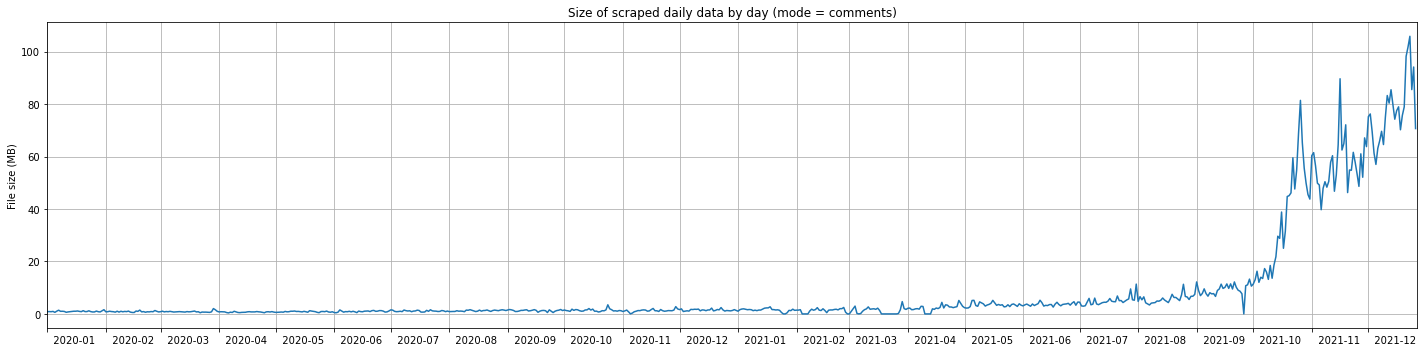

In [5]:
# how large are the scraped files for each day?
# a few filesizes are 0MB; this is due to reddit/pushshift outages on those days

for mode in modes:
    mode_dir = path.join(original_dir, mode)
    filenames = sorted(os.listdir(mode_dir))
    filepaths = [path.join(mode_dir, filename) for filename in filenames]

    dates = [filename[:10] for filename in filenames]
    filesizes = np.array(
        [path.getsize(filepath) for filepath in filepaths]) / (1024**2)

    if True:
        plt.figure(figsize=(20, 5))
        plt.plot(filesizes)

        plt.title(f"Size of scraped daily data by day (mode = {mode})")
        plt.ylabel("File size (MB)")
        plt.xlim(0, len(dates))
        plt.xticks(
            ticks=[i for i, date in enumerate(dates) if date.endswith("01")], 
            labels=["  " + date[:-3] for date in dates if date.endswith("01")], 
            ha="left")
        plt.grid()
        plt.tight_layout()
        plt.show()

### Exploration of all scraped posts

In [6]:
# prepwork
mode = 'posts'
posts_dir = path.join(original_dir, mode)

# load scraped posts
posts = []
for filename in tqdm(sorted(os.listdir(posts_dir))):
    filepath = path.join(posts_dir, filename)
    with open(filepath, 'r') as f:
        for line in f:
            x = json.loads(line)
            posts.append(x)
posts = pd.DataFrame(posts)
posts.fillna(False, inplace=True)

100%|██████████| 731/731 [00:25<00:00, 28.73it/s] 


In [7]:
# basic statistics
print(f"Number of posts scraped: {posts.shape[0]}")
print(f"Number of posts removed/deleted: {posts.removed_by_category.apply(lambda x: 1 if x else 0).sum()}")
print(f"Number of posts with no selftext: {posts.selftext.apply(lambda x: 0 if x else 1).sum()}")

idx = (posts.removed_by_category == False) & (posts.selftext.apply(bool))
posts = posts[idx].reset_index()
print(f"Number of posts remaining: {posts.shape[0]}")

Number of posts scraped: 162536
Number of posts removed/deleted: 8266
Number of posts with no selftext: 84668
Number of posts remaining: 72894


In [8]:
# author statistics
print(f"Number of unique authors: {posts.author.nunique()}")
print(f"Number of authors with 1 post: {len([author for author, freq in posts.author.value_counts().items() if freq == 1])}")
print(f"Number of authors with >50 posts: {len([author for author, freq in posts.author.value_counts().items() if freq > 50])}")
print(f"Most prolific authors: {list(posts.author.value_counts()[:5].items())}")

Number of unique authors: 49170
Number of authors with 1 post: 39050
Number of authors with >50 posts: 12
Most prolific authors: [('_Raspootin_', 145), ('Advi0001', 98), ('nbatman', 95), ('isle_of_cats', 88), ('AutoModerator', 85)]


### Exploration of preprocessed posts

The selftext of every post was preprocessed using SpaCy. Every post has three new keys:

- 'tokens': lists of lists of lowercased tokens
- 'lemmas': lists of lists of lowercased lemmas
- 'filtered_lemmas': lists of lists of lowercased lemmas, with stopwords and non-letters removed

Empty tokens and empty sentences are removed.

In [9]:
# prepwork
mode = 'posts'
posts_dir = path.join(preprocessed_dir, mode)

# load preprocessed filtered posts
posts = []
for filename in tqdm(sorted(os.listdir(posts_dir))):
    filepath = path.join(posts_dir, filename)
    with open(filepath, 'r') as f:
        for line in f:
            x = json.loads(line)
            posts.append(x)
posts = pd.DataFrame(posts)
posts.fillna(False, inplace=True)

100%|██████████| 731/731 [00:25<00:00, 28.42it/s] 


In [10]:
# descriptive statistics
print(f"Number of posts scraped: {posts.shape[0]}")

# peek 
x = posts.loc[0]
print(f"Author: {x['author']}\n")
print(f"Original selftext:\n{x['selftext']}\n")
print(f"Lemmas:")
for s in x['lemmas']:
    print(f"- {' '.join(s)}")
print(f"\nFiltered lemmas:")
for s in x['filtered_lemmas']:
    print(f"- {' '.join(s)}")

Number of posts scraped: 72894
Author: coffeeandamuffin

Original selftext:
WTF are you celebrating? Another year of indentured slavery?

Lemmas:
- wtf be you celebrate ?
- another year of indenture slavery ?

Filtered lemmas:
- wtf celebrate
- year indenture slavery


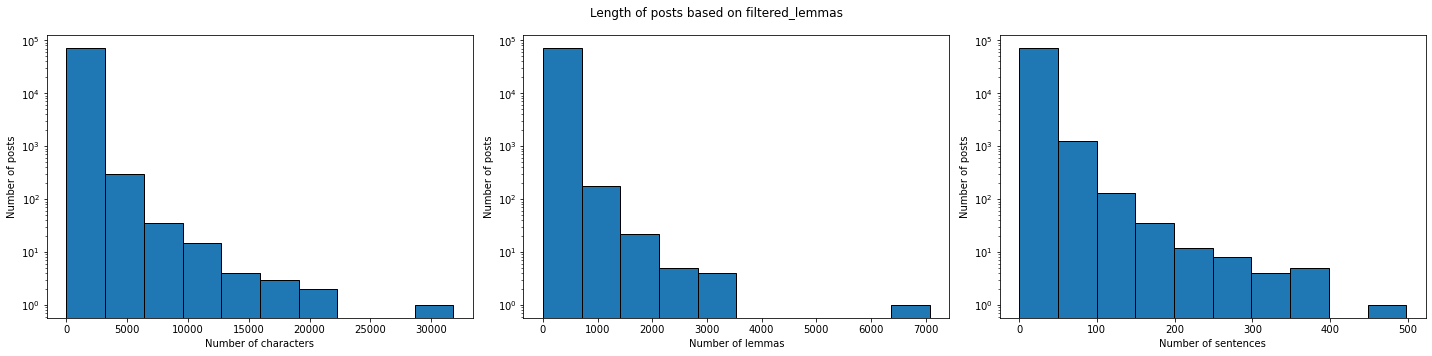

In [11]:
# compute descriptive statistics
key = 'filtered_lemmas'
stats = {'characters': [], 'lemmas': [], 'sentences': []}
stats['characters'] = posts[key].apply(
    lambda x: sum([len(lem) for sent in x for lem in sent])
)
stats['lemmas'] = posts[key].apply(
    lambda x: sum([len(sent) for sent in x])
)
stats['sentences'] = posts[key].apply(len)

# make plots
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
plt.suptitle(f"Length of posts based on {key}")
for i, method in enumerate(stats.keys()):
    axes[i].hist(stats[method], edgecolor='black')
    axes[i].set_yscale('log')

    axes[i].yaxis.set_tick_params(labelleft=True)
    axes[i].set_ylabel(f"Number of posts")
    axes[i].set_xlabel(f"Number of {method}")
plt.tight_layout()
plt.show()

In [12]:
# selftexts with very few filtered lemmas seem to be not meaningful
min_length = 6
short_post_idx = (stats['lemmas'] < min_length)
print(f"Number of posts with <{min_length} filtered lemmas: {sum(short_post_idx)}")
print(f"Examples (original selftexts):")
for t in list(posts[short_post_idx].selftext)[-10:]:
    print(f"- {t}")

Number of posts with <6 filtered lemmas: 4004
Examples (original selftexts):
- &amp;#x200B;

https://preview.redd.it/6fjgifghsv881.jpg?width=828&amp;format=pjpg&amp;auto=webp&amp;s=2e2f23cd43b4d87daec773f317fee96961ff9ebf
- &amp;#x200B;

https://preview.redd.it/qj1j6hierv881.png?width=1016&amp;format=png&amp;auto=webp&amp;s=63e3ad68f3c244bb8d49005ac3d6dd4196840d82
- &amp;#x200B;

https://preview.redd.it/e134nhxyxx881.png?width=1441&amp;format=png&amp;auto=webp&amp;s=5b47995a9d9462f75ccc8bb48dba5a1a408892f6
- Roughly a $8 retail value
- You heard me
- See post title and vote yes or no in the comments.
- &amp;#x200B;

https://preview.redd.it/0bma6gozfw881.png?width=964&amp;format=png&amp;auto=webp&amp;s=368e8745e7607d7ac5bfb442a487fcac3375fc71
- Saying that because that's basically how I see it happening in this country
- r/antiwork is ageist as fuck. Disappointing.
- Just a friendly reminder..


Total number of unique lemmas (without stopwords): 54591


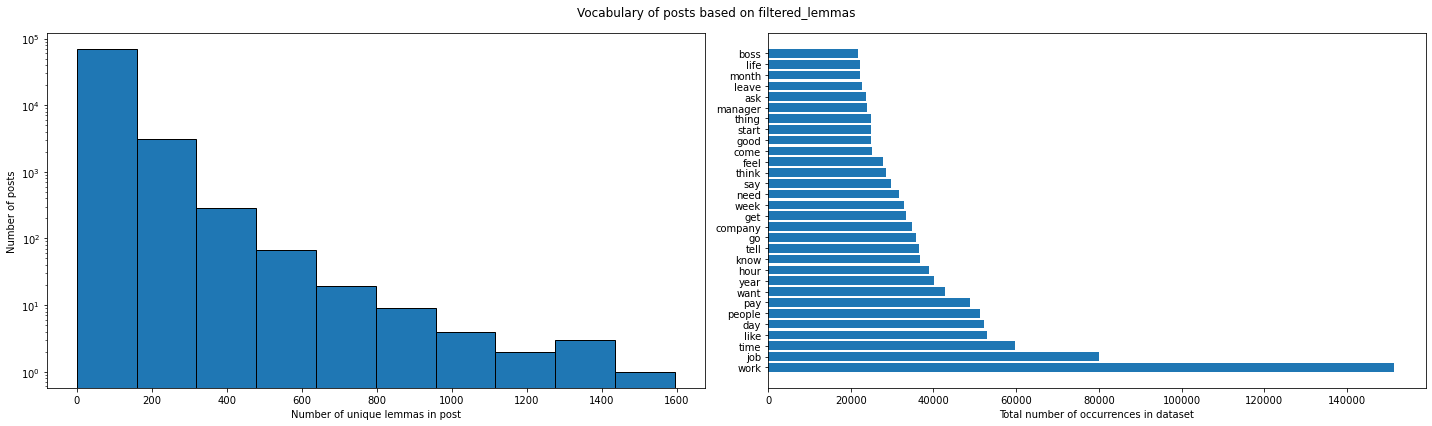

In [13]:
# vocabulary per post and total vocabulary
vocab_per_post = posts.filtered_lemmas.apply(
    lambda x: Counter([lem for sent in x for lem in sent])
)
total_vocab = Counter()
for vocab in vocab_per_post:
    total_vocab.update(vocab)

print(f"Total number of unique lemmas (without stopwords): {len(total_vocab)}")

if True:
    f, axes = plt.subplots(1, 2, figsize=(20, 6))
    plt.suptitle("Vocabulary of posts based on filtered_lemmas")

    axes[0].hist(vocab_per_post.apply(len), edgecolor='black')
    axes[0].set_yscale('log')

    axes[0].set_ylabel("Number of posts")
    axes[0].set_xlabel("Number of unique lemmas in post")

    top_words, top_freqs = zip(*total_vocab.most_common(30))
    axes[1].barh(top_words, top_freqs)
    axes[1].set_xlabel("Total number of occurrences in dataset")

    plt.tight_layout()
    plt.show()

In [15]:
# get frequency of lemmas (in number of posts)
filepath = path.join(outs_dir, 'lemma-to-n-posts.json')
if path.exists(filepath):
    with open(filepath, 'r') as f:
        lemma_to_n_posts = json.load(f)
else:
    lemma_to_n_posts = {}
    for lem in tqdm(total_vocab):
        n_posts = vocab_per_post.apply(lambda x: lem in x).sum()
        lemma_to_n_posts[lem] = n_posts

    # export
    with open(filepath, 'w') as f_out:
        json.dump(lemma_to_n_posts, fp=f_out)

lemma_to_n_posts = Counter(lemma_to_n_posts)

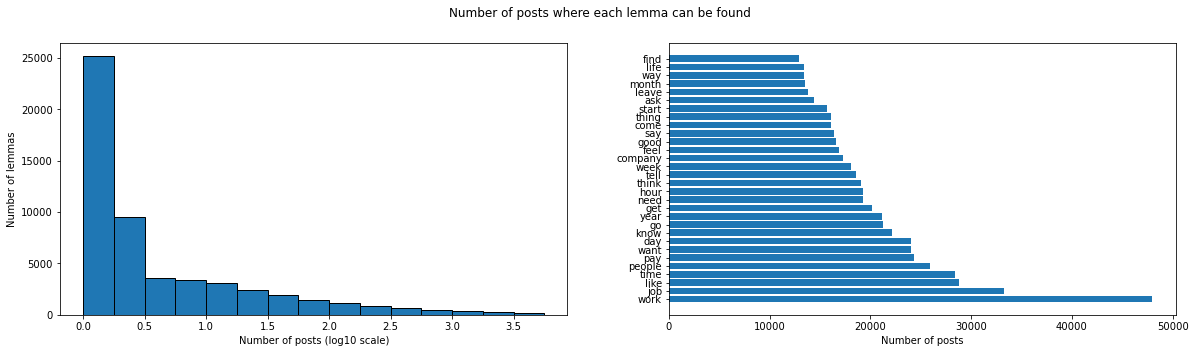

In [21]:
# lemmas frequency in number of posts
f, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle("Number of posts where each lemma can be found")

axes[0].hist(
    np.log10(list(lemma_to_n_posts.values())), 
    bins=np.arange(0, 4, 0.25), edgecolor='black')
axes[0].set_ylabel("Number of lemmas")
axes[0].set_xlabel("Number of posts (log10 scale)")

top_lemmas, top_n_posts = zip(*lemma_to_n_posts.most_common(30))
axes[1].barh(top_lemmas, top_n_posts)
axes[1].set_xlabel("Number of posts")
plt.show()

In [17]:
# lemmas that appear only in very few posts are usually typos/not meaningful
min_n_posts = 6
rare_lemmas = [
    lem for lem, n_posts in lemma_to_n_posts.items() 
    if n_posts < min_n_posts]
print(f"Number of lemmas appearing in <{min_n_posts}: {len(rare_lemmas)}")
print(f"Examples: {' '.join(rare_lemmas[:50])}")

Number of lemmas appearing in <6: 38311
Examples: ediscovery aml firein bme bawling fineeeee experoence enticement mobster undateable fba consultants mayer cardone yesteday dissatisfy fourtie hideously mitten boris bumb brains unrewarde commercially alarmist freakish deadborn nomatter foward increasirngly enioy naborhood stupie nickalapolis narccistic ostracise siginifcant overpopulate hecke frigging restuarant milennial diahrea celebrated devotional butch wriggle nougat bleh woeisme
